# Simple Reinforcement Learning with Tensorflow: Part 3 - Model-Based RL
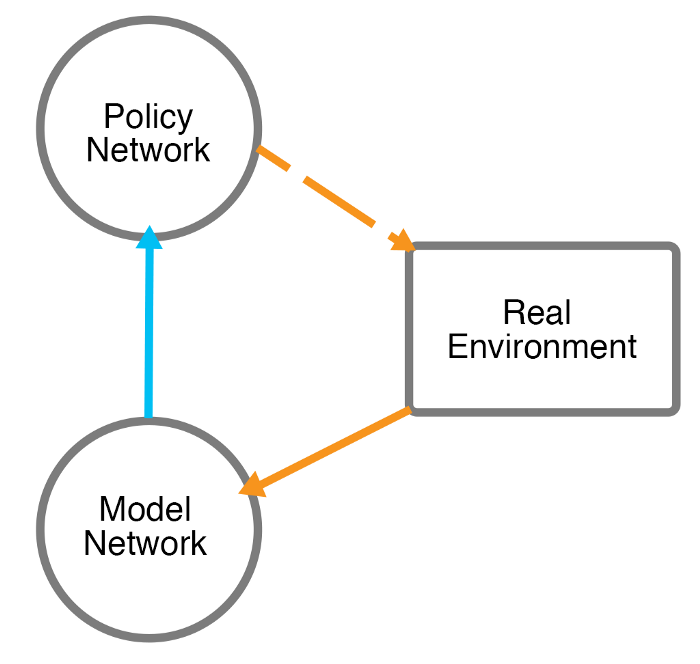

* neural network를 이용해 모델을 만들어 보자.
    * 모델을 만들면 매 시각에 실제 환경을 이용하지 않아도 agent는 모델을 이용해 학습을 진행할 수 있다.
    * 실제 물리적 환경을 이용하는 것은 시간이 많이 걸릴뿐만 아니라, 제약 사항이 많다.
        * 대신 모델을 만들어 사용하면 이를 예방할 수 있다.
* 이전 관측과 action 사이의 transition dynamics와 기대되는 새로운 관측, reward, terminal state를 학습하는 neural network를 만들어보자.
    * 실제 물리 환경을 사용한 모델 학습과 모델 환경을 이용해 agent의 policy를 학습하는 과정을 포함한다.
 

In [1]:
"""
Loading libraries and starting CartPole environment
"""
import numpy as np
import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

In [4]:
"""
Setting Hyper-parameters
"""
# 하이퍼파라미터
H = 8 # 은닉층 뉴런 개수
learning_rate = 1e-2
gamma = 0.99 # discount factor
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # checkpoint에서 resume 여부

model_bs = 3 # 모델로부터 학습시 batch size
real_bs = 3 # 물리 환경으로부터 학습시 batch size

# 모델 초기화
D = 4 # input dimensionality

In [9]:
"""
Policy Network
"""
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = -tf.reduce_mean(loglik * advantages) 
newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

In [11]:
"""
Model Network
"""
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

In [17]:
"""
Helper-functions
"""
def resetGradBuffer(gradBuffer):
    for ix, grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    
    return gradBuffer

def discount_rewards(r):
    """
    1차원 reward 배열을 가지고 discounted reward를 계산한다.
    """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

# 이전 시각의 state와 action을 가지고 새로운 state를 생성
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

In [22]:
"""
Training the Policy and Model
"""
xs, drs, ys, ds = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

# True일 경우, 관측을 위해 model을 사용하게 된다.
drawFromModel = False

# 모델 학습 여부
trainTheModel = True

# policy 학습 여부
trainThePolicy = False

switch_point = 1

with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # performance가 충분히 좋아지면 환경을 표시하기 시작한다.
        if ((reward_sum / batch_size) > 150 and drawFromModel == False) or rendering == True:
            env.render()
            rendering = True
            
        x = np.reshape(observation, [1, 4])
        
        tfprob = sess.run(probability, feed_dict = {observations: x})
        if np.random.uniform() < tfprob: action = 1 
        else: 0
        
        # 중간 변수 기록(역전파시 필요)
        xs.append(x)
        y = 1 if action == 0 else 0
        ys.append(y)
        
        # 모델 또는 실제 환경에서 학습 진행하고 새로운 값을 얻는다
        if drawFromModel == False: # 실제 환경에서 수행
            observation, reward, done, info = env.step(action)
        else: # 모델에서 수행
            observation, reward, done = stepModel(sess, xs, action)
            
        reward_sum += reward
        
        ds.append(done * 1)
        # reward 기록(이전 action에 대한 reward를 얻기 위해 step()을 수행한 후 이뤄진다.
        drs.append(reward)
        
        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # 현재 에피소드의 모든 inputs, hidden states, action gradients, reward를 쌓는다.
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # 배열 초기화
            
            if trainTheModel == True:
                actions = np.array([np.abs(y-1) for y in epy][:-1])
                state_prevs = epx[:-1,:]
                state_prevs = np.hstack([state_prevs,actions])
                state_nexts = epx[1:,:]
                rewards = np.array(epr[1:,:])
                dones = np.array(epd[1:,:])
                state_nextsAll = np.hstack([state_nexts,rewards,dones])

                feed_dict={previous_state: state_prevs, true_observation: state_nexts,true_done:dones,true_reward:rewards}
                loss,pState,_ = sess.run([model_loss,predicted_state,updateModel],feed_dict)
            if trainThePolicy == True:
                discounted_epr = discount_rewards(epr).astype('float32')
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                tGrad = sess.run(newGrads,feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
                
                # gradient가 너무 커지면 학습을 중단한다.
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W2Grad:gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # 모델이 100개의 에피소드 동안 학습을 진행하고 나면 policy를 학습하는 모델과 실제 환경을 학습하는 모델을 교체해준다.
                if episode_number > 100:
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
            
print(real_episodes)

World Perf: Episode 4.000000. Reward 10.000000. action: 1.000000. mean reward 10.000000.
World Perf: Episode 7.000000. Reward 9.666667. action: 1.000000. mean reward 9.996667.
World Perf: Episode 10.000000. Reward 9.666667. action: 1.000000. mean reward 9.993367.
World Perf: Episode 13.000000. Reward 9.333333. action: 1.000000. mean reward 9.986766.
World Perf: Episode 16.000000. Reward 10.000000. action: 1.000000. mean reward 9.986899.
World Perf: Episode 19.000000. Reward 9.333333. action: 1.000000. mean reward 9.980363.
World Perf: Episode 22.000000. Reward 9.333333. action: 1.000000. mean reward 9.973893.
World Perf: Episode 25.000000. Reward 8.666667. action: 1.000000. mean reward 9.960820.
World Perf: Episode 28.000000. Reward 9.333333. action: 1.000000. mean reward 9.954546.
World Perf: Episode 31.000000. Reward 9.333333. action: 1.000000. mean reward 9.948333.
World Perf: Episode 34.000000. Reward 9.000000. action: 1.000000. mean reward 9.938850.
World Perf: Episode 37.000000. 

World Perf: Episode 304.000000. Reward 8.333333. action: 1.000000. mean reward 10.823433.
World Perf: Episode 307.000000. Reward 9.000000. action: 1.000000. mean reward 10.745404.
World Perf: Episode 310.000000. Reward 9.666667. action: 1.000000. mean reward 10.826587.
World Perf: Episode 313.000000. Reward 9.333333. action: 1.000000. mean reward 10.781259.
World Perf: Episode 316.000000. Reward 8.666667. action: 1.000000. mean reward 10.709835.
World Perf: Episode 319.000000. Reward 10.000000. action: 1.000000. mean reward 13.274253.
World Perf: Episode 322.000000. Reward 8.666667. action: 1.000000. mean reward 13.189281.
World Perf: Episode 325.000000. Reward 8.333333. action: 1.000000. mean reward 13.066623.
World Perf: Episode 328.000000. Reward 10.000000. action: 1.000000. mean reward 13.090287.
World Perf: Episode 331.000000. Reward 9.000000. action: 1.000000. mean reward 15.395134.
World Perf: Episode 334.000000. Reward 9.666667. action: 1.000000. mean reward 15.242200.
World Pe

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previou

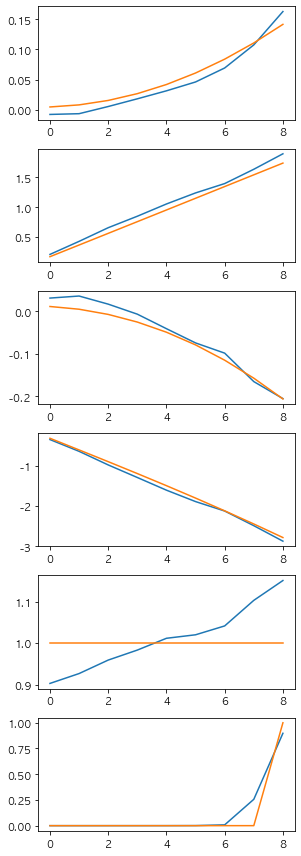

In [23]:
"""
Checking model representation
"""
# 초록색: 실제 환경 / 파란색: 모델 예측
plt.figure(figsize = (8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:, i])
    plt.subplot(6, 2, 2*i+1)
    plt.plot(state_nextsAll[:, i])
plt.tight_layout()

* 열심히 적기는 했는데... 코드 설명이 자세하지 않아서 코드를 잘 이해하지 못하겠다 엉엉 이게 과연 공부했다고 할 수 있을지, 그냥 타이핑 연습한건 아닌지...?